## Transfer Learning with Pytorch

This tutorial introduces how to perform transfer learning with Pytorch. This follows the tutorial on

- [1] http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time, copy
from pathlib import Path

# PLT in interactive mode
plt.ion()

### Load the Data

We want to classify Bees and Ants. We will be training on 120 images.

In [2]:
# Data augmentation and normalization for training. For validation just normalize.
# This uses the transforms from torchvision module
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Use torchvision module to load datasets from file
data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(str(Path(data_dir) / x), data_transforms[x]) for x in ['train', 'val']}

# Data loaders (here is where you define batch sizes and shuffling)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                             batch_size=4,
                                             shuffle=True,
                                             num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Need to explicitly denote whether to use GPU with pytorch
use_gpu = torch.cuda.is_available()

### Visualize Images

Lets visualize some of the images

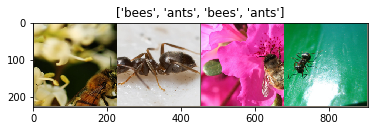

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.0001)
    
# Get a batch of the training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Train the model

Train model using learning rate scheduling and saving best model.

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    """Train a model.
    :param scheduler: a LR scheduler object from torch.optim.lr_scheduler
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    
    for epoch in range(num_epochs):
        print('Epoch %s/%s' % (epoch, num_epochs - 1))
        print('-' * 10) # Nice little trick there
        
        # Every epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # Train mode
            if phase == 'val':
                model.train(False) # Validation mode
                
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over the data
            for data in dataloaders[phase]:
                # Unpack inputs from data
                inputs, labels = data

                
                # Wrap them in a variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                print('inputs', inputs)
                print('labels', labels)
                
                # Zero the optimizer gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                print('outputs', outputs)
                _, preds = torch.max(outputs.data, 1) # Maximum prediction
                loss = criterion(outputs, labels)
                
                # Backwards pass
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    
                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print('%s Loss: %.4f Acc: %.4f' % (phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        print()
        
    time_elapsed = time.time() - since
    print('Trainig complete in %.0fm %.0fs' % (time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: %.4f' % best_acc)
    
    # Load the best model weights and return the trained model
    model.load_state_dict(best_model_wts)
    return model            

### Visualizing model prediction

In [6]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        # Unpack inputs from data
        inputs, labels = data
        # Wrap them in a variable
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        # Feed forward, get max prediction
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: %s' % class_names[preds[j]])
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

### Finetune the convnet

Load a pre-trained model and reset the final layer

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2) # 2 classes, same features as previous fc layer

if use_gpu:
    model_ft = model_ft.cuda()

# Loss function comes from torch.nn module
criterion = nn.CrossEntropyLoss()

# Observe all parameters being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Scheduler to decay learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### Train the model

Note that we are letting the gradients propagate through the entire resnet model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

# Visualize output
visualize_model(model_ft)

### Conv-net as a fixed feature extractor

In the previous training, we let the gradients go back through the entire feature extractor. This is kind of unecessary, so lets instead freeze the conv base. This will increase training speed.

In [7]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False # Freeze the layer

# Parameters in newly constructed layers have requires_grad = True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# We only optimize parameters in the final layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Learning rate decay
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

visualize_model(model_conv)

plt.ioff()
plt.show()

Epoch 0/24
----------
inputs Variable containing:
( 0 , 0 ,.,.) = 
 -1.7412 -1.8953 -1.8268  ...   0.2282 -0.0287 -0.7137
 -1.6898 -1.8268 -1.8782  ...   0.1768  0.1254 -0.4911
 -1.6213 -1.7754 -1.8782  ...   0.3652  0.5193 -0.2171
           ...             ⋱             ...          
 -1.3644 -0.9192 -0.4911  ...  -1.5357 -1.5870 -1.8097
 -1.1589 -1.2959 -1.2103  ...  -1.5870 -1.6555 -1.5185
 -0.9877 -1.2103 -1.3815  ...  -1.5870 -1.5357 -0.9192

( 0 , 1 ,.,.) = 
 -1.2654 -1.4755 -1.3354  ...  -1.1954 -1.0903 -1.2479
 -1.2654 -1.4755 -1.4755  ...  -0.9153 -0.6877 -0.9853
 -1.2304 -1.4755 -1.5105  ...  -0.4776 -0.1450 -0.6877
           ...             ⋱             ...          
 -0.6527 -0.2325  0.2052  ...  -1.2654 -1.1954 -1.3529
 -0.3200 -0.5301 -0.4776  ...  -1.2829 -1.1954 -0.8803
 -0.0749 -0.3725 -0.6001  ...  -1.2129 -0.9853 -0.1450

( 0 , 2 ,.,.) = 
 -1.6476 -1.6476 -1.6999  ...  -1.6302 -1.6127 -1.7696
 -1.6476 -1.6302 -1.6999  ...  -1.6999 -1.5953 -1.6650
 -1.6302 -1.6650 

outputs Variable containing:
 0.8715 -0.9650
 1.2770  0.0076
 0.3213 -1.2558
 0.8140 -0.5098
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

inputs Variable containing:
( 0 , 0 ,.,.) = 
  0.2796  0.2796  0.2624  ...  -0.9534 -0.9363 -0.9363
  0.2796  0.2796  0.2624  ...  -0.9534 -0.9363 -0.9363
  0.2624  0.2624  0.2624  ...  -0.9534 -0.9534 -0.9534
           ...             ⋱             ...          
 -0.5424 -0.5424 -0.5424  ...   1.2728  1.2899  1.3070
 -0.5424 -0.5424 -0.5424  ...   1.2728  1.2899  1.2899
 -0.5424 -0.5424 -0.5424  ...   1.2728  1.2899  1.2899

( 0 , 1 ,.,.) = 
  1.0105  1.0105  0.9930  ...  -0.4601 -0.4426 -0.4426
  1.0105  1.0105  0.9930  ...  -0.4601 -0.4426 -0.4426
  0.9930  0.9930  0.9930  ...  -0.4601 -0.4601 -0.4601
           ...             ⋱             ...          
  0.2752  0.2752  0.2752  ...   0.2577  0.2402  0.2402
  0.2752  0.2752  0.2752  ...   0.2402  0.2577  0.2927
  0.2752  0.2752  0.2752  ...   0.2402  0.2927  0.3277

( 0 , 2 ,.,.) = 
 -0.4624 -

inputs Variable containing:
( 0 , 0 ,.,.) = 
  0.7077  0.6734  0.6734  ...   1.4954  1.4612  1.5125
  0.7077  0.7248  0.7419  ...   1.5125  1.5297  1.5810
  0.7419  0.7591  0.7933  ...   1.5297  1.5468  1.5810
           ...             ⋱             ...          
  1.5639  1.6153  1.6153  ...   1.8379  1.8379  1.8550
  1.5468  1.6153  1.6495  ...   1.8379  1.8379  1.8550
  1.5982  1.6495  1.5982  ...   1.8379  1.8379  1.8379

( 0 , 1 ,.,.) = 
  0.9930  0.9230  0.9230  ...   1.8333  1.8683  1.9034
  0.9755  0.9930  0.9755  ...   1.8158  1.8508  1.8859
  1.0280  1.0455  1.0105  ...   1.8333  1.8683  1.9034
           ...             ⋱             ...          
  1.8508  1.9209  1.9209  ...   2.0959  2.0959  2.0784
  1.8683  1.9384  1.9559  ...   2.0784  2.0784  2.0959
  1.9034  1.9559  1.9034  ...   2.0784  2.0784  2.0784

( 0 , 2 ,.,.) = 
  1.6291  1.5942  1.5768  ...   2.5180  2.5354  2.5703
  1.6465  1.6117  1.6465  ...   2.4831  2.5006  2.5354
  1.6640  1.5942  1.6814  ...   2.5006 

outputs Variable containing:
-0.1136  0.1072
-0.5662 -0.2451
-0.1029  0.0248
 0.8135  0.5305
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

inputs Variable containing:
( 0 , 0 ,.,.) = 
  0.8447  0.7933  0.7933  ...   1.6838  1.7009  1.3584
  0.8618  0.9303  0.9132  ...   1.6324  1.5468  1.4098
  0.6049  0.5193  0.3481  ...   1.9578  1.3755  1.0673
           ...             ⋱             ...          
  1.4098  1.1529  1.0159  ...   0.8961  1.0159  1.0673
  1.5982  1.2557  1.0673  ...   1.1872  1.2728  1.3927
  1.4269  1.2557  1.1015  ...   1.2899  1.5125  1.7352

( 0 , 1 ,.,.) = 
  0.4153  0.3452  0.3452  ...   1.5532  1.4307  1.0630
  0.3102  0.3277  0.2927  ...   1.3782  1.3081  1.1856
 -0.0574 -0.1275 -0.3200  ...   1.5882  1.0805  0.8529
           ...             ⋱             ...          
  1.0455  0.8179  0.7479  ...   0.9930  1.1681  1.2206
  1.1681  0.8880  0.8004  ...   1.2556  1.4132  1.5707
  0.9930  0.8354  0.8179  ...   1.4482  1.7108  1.9734

( 0 , 2 ,.,.) = 
  0.3742  

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -0.5253 -0.5253 -0.5253  ...  -0.7822 -0.7822 -0.7822
 -0.5253 -0.5253 -0.5253  ...  -0.7822 -0.7993 -0.7993
 -0.5082 -0.5082 -0.5082  ...  -0.7822 -0.7822 -0.7993
           ...             ⋱             ...          
  0.7248  0.8618  0.6906  ...   0.1597  0.1426  0.1426
  0.8276  0.8961  0.6221  ...   0.1597  0.1597  0.1597
  0.8618  0.8447  0.5193  ...   0.1768  0.1597  0.1597

( 0 , 1 ,.,.) = 
 -0.7052 -0.7052 -0.7052  ...  -0.8627 -0.8627 -0.8627
 -0.7052 -0.7052 -0.7052  ...  -0.8452 -0.8452 -0.8452
 -0.7052 -0.7052 -0.7052  ...  -0.8277 -0.8277 -0.8452
           ...             ⋱             ...          
  0.3627  0.5203  0.3102  ...  -0.0224 -0.0399 -0.0399
  0.5903  0.6078  0.2577  ...  -0.0224 -0.0399 -0.0574
  0.6254  0.5378  0.1176  ...  -0.0399 -0.0574 -0.0574

( 0 , 2 ,.,.) = 
 -0.6541 -0.6541 -0.6541  ...  -0.7413 -0.7413 -0.7413
 -0.6541 -0.6541 -0.6541  ...  -0.7413 -0.7761 -0.7761
 -0.6541 -0.6541 -0.6715  ...  -0.7587 

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -0.2513 -0.2513 -0.1486  ...  -0.5082 -0.5082 -0.3369
 -0.3369 -0.1657 -0.1314  ...  -0.5082 -0.4226 -0.3883
 -0.3712 -0.1486 -0.1314  ...  -0.4226 -0.4397 -0.3027
           ...             ⋱             ...          
 -0.6794 -0.5596 -0.2513  ...  -0.3712  0.0741  0.5193
 -0.5082 -0.4226 -0.1143  ...   0.1939  0.0569  0.1939
 -0.6452 -0.7137 -0.8164  ...   0.0569  0.3138  0.3481

( 0 , 1 ,.,.) = 
 -0.1975 -0.1800  0.0126  ...  -0.3025 -0.2325 -0.1450
 -0.2675 -0.0924 -0.0399  ...  -0.1450 -0.1099 -0.1975
 -0.3200 -0.1099 -0.1099  ...  -0.1275 -0.2150 -0.1275
           ...             ⋱             ...          
 -0.5651 -0.5301 -0.1800  ...  -0.2325  0.2227  0.7654
 -0.5651 -0.4776 -0.0574  ...   0.2752  0.1352  0.3452
 -0.6352 -0.6176 -0.6352  ...   0.1352  0.3803  0.4853

( 0 , 2 ,.,.) = 
  0.2348  0.1651  0.3568  ...   0.4091  0.4091  0.4614
  0.1128  0.1999  0.3219  ...   0.4439  0.5311  0.4439
  0.0953  0.2522  0.3393  ...   0.4614 

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -1.0048 -1.0048 -1.0562  ...  -2.1179 -2.1179 -2.1179
 -1.2445 -1.3302 -1.3130  ...  -2.1179 -2.1179 -2.1179
 -1.2103 -1.2617 -1.3302  ...  -2.1179 -2.1179 -2.1179
           ...             ⋱             ...          
  2.1633  2.1462  2.1804  ...   2.1633  2.2147  2.2489
  2.2318  2.1975  2.1804  ...   2.1290  2.2318  2.1975
  2.2489  2.2318  2.1804  ...   2.2147  2.2147  2.1975

( 0 , 1 ,.,.) = 
 -1.6856 -1.6856 -1.7031  ...  -2.0357 -2.0357 -2.0357
 -1.8256 -1.9307 -1.8782  ...  -2.0357 -2.0357 -2.0357
 -1.7031 -1.7731 -1.8256  ...  -2.0357 -2.0357 -2.0357
           ...             ⋱             ...          
 -0.1450 -0.1975 -0.1450  ...   1.0105  0.8529  0.5553
  0.0476 -0.0224 -0.0399  ...   0.9930  0.8179  0.5028
  0.1527  0.1001  0.0651  ...   0.9055  0.7304  0.5378

( 0 , 2 ,.,.) = 
 -0.8110 -0.8284 -0.8807  ...  -1.8044 -1.8044 -1.8044
 -1.0376 -1.1596 -1.1596  ...  -1.8044 -1.8044 -1.8044
 -0.9678 -1.0898 -1.1770  ...  -1.8044 

outputs Variable containing:
-0.9465  1.2358
-0.4231 -0.1333
-1.2130  0.3877
 1.9286 -0.3408
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

inputs Variable containing:
( 0 , 0 ,.,.) = 
  0.4508  0.4851  0.5193  ...   0.8447  0.8618  0.8961
  0.4508  0.4851  0.5707  ...   0.8447  0.8618  0.8961
  0.3994  0.4508  0.5536  ...   0.8276  0.8447  0.8961
           ...             ⋱             ...          
  0.7933  0.6392  0.0912  ...   1.1529  1.1700  1.1872
  0.9988  0.9132  0.4166  ...   1.2214  1.2385  1.2728
  1.1015  1.0159  0.5707  ...   1.3242  1.3584  1.3584

( 0 , 1 ,.,.) = 
 -0.0924 -0.0574  0.0126  ...   0.6429  0.7129  0.7479
 -0.1625 -0.0924  0.0126  ...   0.6429  0.7129  0.7479
 -0.2500 -0.1800 -0.0749  ...   0.6254  0.6779  0.7129
           ...             ⋱             ...          
  0.6604  0.6078  0.1352  ...   0.6604  0.7129  0.7479
  0.8880  0.8880  0.5028  ...   0.7479  0.7654  0.8004
  0.9930  0.9930  0.6604  ...   0.8354  0.8354  0.8704

( 0 , 2 ,.,.) = 
 -0.5495 -

outputs Variable containing:
-1.1105  0.5621
 0.8480  0.0319
 0.6752 -0.5748
-0.4929  0.7352
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -0.8335 -1.2274 -0.7993  ...  -0.5596 -0.5938 -0.6281
 -0.9534 -1.2445 -1.0048  ...  -0.4739 -0.5082 -0.5596
  0.1426 -0.3541 -0.3198  ...  -0.5767 -0.5938 -0.5253
           ...             ⋱             ...          
  0.9988  1.1358  1.2043  ...   1.1015  1.0331  1.0844
  1.3070  1.4612  1.5125  ...   1.0502  0.9474  1.0502
  1.5125  1.5297  1.5810  ...   0.9988  0.9132  0.9817

( 0 , 1 ,.,.) = 
 -0.7927 -1.0378 -0.8102  ...  -0.0924 -0.1099 -0.0749
 -0.6001 -1.0203 -0.9678  ...  -0.1275 -0.1450 -0.1625
 -0.0049 -0.3725 -0.3550  ...  -0.1625 -0.1800 -0.0924
           ...             ⋱             ...          
  0.9930  1.1506  1.2906  ...   0.4328  0.3803  0.4503
  1.3431  1.5357  1.6408  ...   0.3627  0.3277  0.4678
  1.6232  1.5357  1.5357  ...   0.3277  0.3277  0.4503

( 0 , 2 ,.,.) = 
 -1.0724 -

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -1.0733 -1.0733 -1.0562  ...  -0.4568 -0.4568 -0.4568
 -1.0562 -1.0562 -1.0390  ...  -0.4397 -0.4568 -0.4568
 -1.0219 -1.0219 -1.0219  ...  -0.4226 -0.4397 -0.4397
           ...             ⋱             ...          
 -0.4568 -0.4054 -0.3541  ...  -0.5767 -0.5767 -0.6109
 -0.4226 -0.3883 -0.3369  ...  -0.5767 -0.5767 -0.6109
 -0.4226 -0.4054 -0.3369  ...  -0.6109 -0.5938 -0.6109

( 0 , 1 ,.,.) = 
 -1.0553 -1.0553 -1.0378  ...  -0.7752 -0.7752 -0.7752
 -1.0378 -1.0378 -1.0203  ...  -0.7577 -0.7752 -0.7752
 -1.0378 -1.0378 -1.0203  ...  -0.7577 -0.7752 -0.7927
           ...             ⋱             ...          
 -0.3901 -0.3550 -0.2850  ...  -0.7752 -0.7752 -0.7927
 -0.4251 -0.3901 -0.3200  ...  -0.7927 -0.7927 -0.8277
 -0.4426 -0.4251 -0.3375  ...  -0.8102 -0.8102 -0.8277

( 0 , 2 ,.,.) = 
 -0.8981 -0.8981 -0.8807  ...  -0.9156 -0.9330 -0.9330
 -0.8807 -0.8807 -0.8633  ...  -0.9330 -0.9330 -0.9330
 -0.8807 -0.8633 -0.8458  ...  -0.9156 

outputs Variable containing:
 0.1117  0.0946
 1.2532 -0.5707
 0.4813 -0.4311
 0.8573 -0.9652
[torch.cuda.FloatTensor of size 4x2 (GPU 0)]

inputs Variable containing:
( 0 , 0 ,.,.) = 
 -0.2171 -0.6452  0.0227  ...   1.3755  1.3242  1.4440
 -0.2856  0.7591  1.1187  ...   1.3927  1.3755  1.5125
  1.2899  0.7419 -0.5938  ...   1.4269  1.4612  1.4954
           ...             ⋱             ...          
  0.3823  0.4166  0.3823  ...  -0.8849 -1.1418 -0.9877
  0.5193  0.4679  0.4337  ...  -0.7993 -0.9705 -1.0390
  0.6392  0.5022  0.4508  ...  -0.7308 -0.7479 -0.8164

( 0 , 1 ,.,.) = 
 -1.0203 -1.2654 -1.1779  ...   1.0980  1.1155  1.2031
 -1.3354 -1.0203 -0.4951  ...   1.1331  1.1506  1.3081
 -0.4601 -0.6877 -1.3354  ...   1.1856  1.2731  1.2906
           ...             ⋱             ...          
 -0.2675 -0.2500 -0.1975  ...  -0.2150 -0.2675 -0.1275
 -0.3200 -0.4251 -0.4251  ...  -0.1275 -0.1275  0.0126
 -0.2150 -0.4076 -0.4251  ...  -0.3025 -0.1275 -0.0749

( 0 , 2 ,.,.) = 
 -1.3861 -

inputs Variable containing:
( 0 , 0 ,.,.) = 
  0.1254  0.1768  0.2111  ...  -0.2171 -0.2342  0.0056
  0.3652  0.3652  0.3823  ...  -0.1657  0.0569  0.3309
  0.5536  0.5364  0.4679  ...   0.2453  0.6563  0.7419
           ...             ⋱             ...          
  1.8037  1.9749  2.0263  ...   0.3823 -0.4568 -0.9534
  1.4783  1.8379  1.9235  ...   0.5022 -0.1486 -1.5357
  0.8789  1.5982  1.8550  ...   0.1939  0.8789 -0.3541

( 0 , 1 ,.,.) = 
  0.0826  0.1176  0.1001  ...  -0.7227 -0.7402 -0.3901
  0.2577  0.2752  0.3102  ...  -0.7402 -0.4076  0.1001
  0.3978  0.4328  0.5028  ...  -0.0924  0.2402  0.3803
           ...             ⋱             ...          
  1.8158  1.9909  2.0784  ...   0.1176 -0.8803 -1.1779
  1.4832  1.8158  1.9559  ...   0.2227 -0.3901 -1.7381
  0.9930  1.5532  1.7283  ...   0.0651  0.7129 -0.6352

( 0 , 2 ,.,.) = 
 -0.1835 -0.0092  0.0431  ...  -1.2990 -1.1944 -0.6367
  0.0605  0.1128  0.2696  ...  -0.9678 -0.5495 -0.2707
  0.3219  0.4091  0.5136  ...  -0.2010 

inputs Variable containing:
( 0 , 0 ,.,.) = 
  2.2318  2.2489  2.2489  ...  -0.4568 -0.4397 -0.2342
  2.2147  2.2318  2.2318  ...   0.3823  0.4166  0.6221
  2.2147  2.2489  2.2489  ...   1.1529  1.1700  1.2728
           ...             ⋱             ...          
  2.1462  2.1119  2.0948  ...  -0.8335 -0.7993 -0.8164
  2.1462  2.1119  2.0777  ...  -0.8164 -0.7479 -0.7822
  2.1119  2.0948  2.0605  ...  -0.7650 -0.7993 -0.8164

( 0 , 1 ,.,.) = 
 -0.4426 -0.4076 -0.3901  ...  -2.0007 -1.9657 -2.0007
 -0.4776 -0.4251 -0.4076  ...  -1.9832 -1.9832 -1.9657
 -0.4951 -0.4426 -0.4076  ...  -1.7906 -1.7906 -1.7381
           ...             ⋱             ...          
 -0.8978 -0.9328 -0.9503  ...  -0.0224  0.0126 -0.0049
 -0.8627 -0.9153 -0.9678  ...  -0.0049  0.0651  0.0301
 -0.9153 -0.9503 -0.9853  ...   0.0126 -0.0049 -0.0224

( 0 , 2 ,.,.) = 
 -1.6824 -1.6127 -1.5604  ...  -1.7522 -1.7347 -1.7347
 -1.7347 -1.6650 -1.5953  ...  -1.7870 -1.7870 -1.7696
 -1.7696 -1.6824 -1.5953  ...  -1.7173 

Process Process-12:
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-10:
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
Process Process-11:
Traceback (most recent call last):
  File "/home/ook/miniconda3/envs/pytorch/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap

Variable containing:
( 0 , 0 ,.,.) = 
 -0.9877 -1.0390 -1.0390  ...  -1.2445 -1.4843 -1.4843
 -0.8507 -0.9705 -1.0390  ...  -1.6213 -1.6213 -0.7137
 -0.7308 -0.8678 -1.0390  ...  -1.1075 -2.0494  0.5707
           ...             ⋱             ...          
  0.0912  0.4166 -0.1828  ...   0.0398 -0.2342 -0.4226
 -0.2342 -0.2684 -0.2513  ...  -0.2171 -0.5596 -0.3883
 -1.0562 -0.1314  1.2728  ...  -0.0458 -0.3883 -0.2513

( 0 , 1 ,.,.) = 
 -1.2304 -1.2654 -1.2654  ...  -1.4230 -1.5805 -1.5280
 -1.0553 -1.1604 -1.2479  ...  -1.6856 -1.8256 -0.7227
 -0.8978 -1.0553 -1.2479  ...  -1.2304 -1.9307  0.7479
           ...             ⋱             ...          
 -0.1800  0.1352 -0.3725  ...  -0.1450 -0.4076 -0.7052
 -0.6176 -0.5126 -0.4251  ...  -0.4951 -0.7577 -0.5301
 -1.3354 -0.1975  1.3957  ...  -0.3725 -0.6001 -0.3200

( 0 , 2 ,.,.) = 
 -1.0724 -1.1073 -1.0724  ...  -1.3164 -1.3513 -1.2990
 -0.9156 -1.0550 -1.0898  ...  -1.5081 -1.6476 -0.4973
 -0.7587 -0.9504 -1.0898  ...  -1.0376 -1.6999

KeyboardInterrupt: 